Higgs search sandbox
---------------------------------

Event selection based on https://arxiv.org/abs/1802.04146

In [1]:
import os

import numpy as np
import scipy as sp
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt

import uproot

In [2]:
data_path = "/afs/cern.ch/user/a/ananiev/cernbox/data/"

In [3]:
datasets = {
    "GamGam": {
        "Data": [
            "data_A.GamGam",
            "data_B.GamGam",
            "data_C.GamGam",
            "data_D.GamGam"
        ],
        "MC": [
            ("mc_341081.ttH125_gamgam.GamGam", {"tag": "tt"}),
            ("mc_343981.ggH125_gamgam.GamGam", {"tag": "gg"}),
            ("mc_345041.VBFH125_gamgam.GamGam", {"tag": "VBF"}),
            ("mc_345318.WpH125J_Wincl_gamgam.GamGam", {"tag": "Wp"}),
            ("mc_345319.ZH125J_Zincl_gamgam.GamGam", {"tag": "Z"})

        ]
    }
}

In [5]:
def yield_events_with_meta(datasets, type_filter=None):
    if type_filter is None:
        type_filter = ["MC"]
    
    for process_name, process in datasets.items():
        print("Process: ", process_name)
        for type_name, thetype in process.items():
            print("Type: ", type_name)
            if type_name not in type_filter:
                continue
            for filedata in thetype:
                try:
                    filename, meta = filedata
                except ValueError:
                    filename = filedata
                    meta = {}
                print("File: ", filename)
                fullpath = os.path.join("root://", data_path, process_name, type_name, f"{filename}.root")
                with uproot.open(fullpath) as f:
                    print("Total Num Events: ", f["mini"].numentries)
                    entrysteps = 100000
                    for i, events in enumerate(f["mini"].iterate(["*"], entrysteps=entrysteps)):
                        print("Processing: ", (i+1)*entrysteps)
                        yield events, meta

In [6]:
def dict_apply_mask(d, mask, fields=None):
    if fields is None:
        fields = d.keys()
    for f in fields:
        d[f] = d[f][mask]

In [7]:
def eta2tg_theta(eta):
    tg_theta = np.exp(-eta)
    tg_theta = 2*tg_theta**2/(1 - tg_theta**2)
    return tg_theta

In [8]:
def atlas_two_cosine(events, p1, p2):
    tg_theta_1 = eta2tg_theta(events[p1+b"_eta"])
    tg_theta_2 = eta2tg_theta(events[p2+b"_eta"])
    cos_delta_phi = np.cos(events[p2+b"_phi"] - events[p1+b"_phi"])
    return (cos_delta_phi + tg_theta_1*tg_theta_2)/np.sqrt((tg_theta_1**2 + 1)*(tg_theta_2**2 + 1))

In [9]:
def photon_filter(events):
    # macro_mask = True
    
    macro_events = {}
    micro_events = {}
    
    macro_events[b"photon_n"] = events[b"photon_n"]
    n_threshold = macro_events[b"photon_n"] >= 2
    macro_mask = n_threshold
    
    micro_events[b"photon_pt"] = events[b"photon_pt"][n_threshold]
    micro_events[b"photon_eta"] = events[b"photon_eta"][n_threshold]
    micro_events[b"photon_phi"] = events[b"photon_phi"][n_threshold]
    micro_events[b"photon_E"] = events[b"photon_E"][n_threshold]
    micro_events[b"photon_isTightID"] = events[b"photon_isTightID"][n_threshold]
    micro_events[b"photon_trigMatched"] = events[b"photon_trigMatched"][n_threshold]
    micro_events[b"photon_ptcone30"] = events[b"photon_ptcone30"][n_threshold]
    micro_events[b"photon_etcone20"] = events[b"photon_etcone20"][n_threshold]
    
    
    pts = micro_events[b"photon_pt"].argsort(ascending=False)
    row_indices = np.arange(pts.shape[0])
    lead_pts = pts[:, 0]
    sublead_pts = pts[:, 1]
    
    
    macro_events[b"photon_n"] = macro_events[b"photon_n"][n_threshold]
    macro_events[b"photon_lead_pt"] = micro_events[b"photon_pt"][row_indices, lead_pts]
    macro_events[b"photon_lead_eta"] = micro_events[b"photon_eta"][row_indices, lead_pts]
    macro_events[b"photon_lead_phi"] = micro_events[b"photon_phi"][row_indices, lead_pts]
    macro_events[b"photon_lead_E"] = micro_events[b"photon_E"][row_indices, lead_pts]
    macro_events[b"photon_lead_isTightID"] = micro_events[b"photon_isTightID"][row_indices, lead_pts]
    macro_events[b"photon_lead_trigMatched"] = micro_events[b"photon_trigMatched"][row_indices, lead_pts]
    macro_events[b"photon_lead_ptcone30"] = micro_events[b"photon_ptcone30"][row_indices, lead_pts]
    macro_events[b"photon_lead_etcone20"] = micro_events[b"photon_etcone20"][row_indices, lead_pts]
    macro_events[b"photon_sublead_pt"] = micro_events[b"photon_pt"][row_indices, sublead_pts]
    macro_events[b"photon_sublead_eta"] = micro_events[b"photon_eta"][row_indices, sublead_pts]
    macro_events[b"photon_sublead_phi"] = micro_events[b"photon_phi"][row_indices, sublead_pts]
    macro_events[b"photon_sublead_E"] = micro_events[b"photon_E"][row_indices, sublead_pts]
    macro_events[b"photon_sublead_isTightID"] = micro_events[b"photon_isTightID"][row_indices, sublead_pts]
    macro_events[b"photon_sublead_trigMatched"] = micro_events[b"photon_trigMatched"][row_indices, sublead_pts]
    macro_events[b"photon_sublead_ptcone30"] = micro_events[b"photon_ptcone30"][row_indices, sublead_pts]
    macro_events[b"photon_sublead_etcone20"] = micro_events[b"photon_etcone20"][row_indices, sublead_pts]
    
    macro_filter = (  (macro_events[b"photon_lead_pt"] > 25000)
                    &
                      (macro_events[b"photon_sublead_pt"] > 25000)
                    &
                      (macro_events[b"photon_lead_isTightID"])
                    &
                      (macro_events[b"photon_sublead_isTightID"])
                    &
                      (macro_events[b"photon_lead_trigMatched"])
                    &
                      (macro_events[b"photon_sublead_trigMatched"])
                    & 
                      (macro_events[b"photon_lead_ptcone30"] < 0.065)
                    & 
                      (macro_events[b"photon_lead_etcone20"] < 0.065)
                    & 
                      (macro_events[b"photon_sublead_ptcone30"] < 0.065)
                    & 
                      (macro_events[b"photon_sublead_etcone20"] < 0.065)
                    & 
                      (  (np.absolute(macro_events[b"photon_lead_eta"]) < 1.37) 
                       | 
                         (  (np.absolute(macro_events[b"photon_lead_eta"]) > 1.52)
                          & (np.absolute(macro_events[b"photon_lead_eta"]) < 2.37)
                         )
                      )
                    & (  (np.absolute(macro_events[b"photon_sublead_eta"]) < 1.37) 
                       | 
                         (  (np.absolute(macro_events[b"photon_sublead_eta"]) > 1.52)
                          & (np.absolute(macro_events[b"photon_sublead_eta"]) < 2.37)
                         )
                      )
                   )
    
    dict_apply_mask(macro_events, macro_filter)
    macro_mask[macro_mask] = macro_filter

    macro_events[b"h_mass"] = np.sqrt(2.*macro_events[b"photon_lead_E"]
                                        *macro_events[b"photon_sublead_E"]
                                        *(1. - atlas_two_cosine(macro_events, b"photon_lead", b"photon_sublead"))
                                     )
    
    mass_cutoff =   (macro_events[b"photon_lead_E"]/macro_events[b"h_mass"] > 0.35) \
                  & (macro_events[b"photon_sublead_E"]/macro_events[b"h_mass"] > 0.25) \
                  & (macro_events[b"h_mass"] >= 105000.) \
                  & (macro_events[b"h_mass"] <= 160000)
    
    dict_apply_mask(macro_events, mass_cutoff)
    macro_mask[macro_mask] = mass_cutoff
    
    return macro_events, macro_mask
#photon_filter(test_events)

In [10]:
def process_event_batch(events, bin_edges, weighted=False):
    filtered_photons, photon_macro_mask = photon_filter(events)
    h_masses = filtered_photons[b"h_mass"]/1000
    if weighted:
        weights = (  events[b"mcWeight"]
                   * events[b'scaleFactor_PILEUP'] 
                   * events[b'scaleFactor_ELE'] 
                   * events[b'scaleFactor_MUON'] 
                   * events[b'scaleFactor_PHOTON'] 
                   * events[b'scaleFactor_TAU'] 
                   * events[b'scaleFactor_BTAG'] 
                   * events[b'scaleFactor_LepTRIGGER'] 
                   * events[b'scaleFactor_PhotonTRIGGER']
                  )[photon_macro_mask]
    else:
        weights = None
    hist = np.histogram(h_masses, bin_edges, weights=weights, density=False)[0]
    return hist
#process_event_batch(test_events, bin_edges)

In [11]:
bin_edges = np.linspace(105., 160., 55, dtype=np.float64)

In [12]:
mc_hist = np.zeros((bin_edges.shape[0] - 1,), dtype=np.float64)
for events, meta in yield_events_with_meta(datasets, type_filter=["MC"]):
    mc_hist += process_event_batch(events, bin_edges, weighted=True)

Process:  GamGam
Type:  Data
Type:  MC
File:  mc_341081.ttH125_gamgam.GamGam
Total Num Events:  576491
Processing:  100000
Processing:  200000
Processing:  300000
Processing:  400000
Processing:  500000
Processing:  600000
File:  mc_343981.ggH125_gamgam.GamGam
Total Num Events:  1054711
Processing:  100000
Processing:  200000
Processing:  300000
Processing:  400000
Processing:  500000
Processing:  600000
Processing:  700000
Processing:  800000
Processing:  900000
Processing:  1000000
Processing:  1100000
File:  mc_345041.VBFH125_gamgam.GamGam
Total Num Events:  497468
Processing:  100000
Processing:  200000
Processing:  300000
Processing:  400000
Processing:  500000
File:  mc_345318.WpH125J_Wincl_gamgam.GamGam
Total Num Events:  113765
Processing:  100000
Processing:  200000
File:  mc_345319.ZH125J_Zincl_gamgam.GamGam
Total Num Events:  230900
Processing:  100000
Processing:  200000
Processing:  300000


In [13]:
data_hist = np.zeros((bin_edges.shape[0] - 1,), dtype=np.float64)
for events, meta in yield_events_with_meta(datasets, type_filter=["Data"]):
    data_hist += process_event_batch(events, bin_edges)

Process:  GamGam
Type:  Data
File:  data_A.GamGam
Total Num Events:  430344
Processing:  100000
Processing:  200000
Processing:  300000
Processing:  400000
Processing:  500000
File:  data_B.GamGam
Total Num Events:  1528717
Processing:  100000
Processing:  200000
Processing:  300000
Processing:  400000
Processing:  500000
Processing:  600000
Processing:  700000
Processing:  800000
Processing:  900000
Processing:  1000000
Processing:  1100000
Processing:  1200000
Processing:  1300000
Processing:  1400000
Processing:  1500000
Processing:  1600000
File:  data_C.GamGam
Total Num Events:  2237187
Processing:  100000
Processing:  200000
Processing:  300000
Processing:  400000
Processing:  500000
Processing:  600000
Processing:  700000
Processing:  800000
Processing:  900000
Processing:  1000000
Processing:  1100000
Processing:  1200000
Processing:  1300000
Processing:  1400000
Processing:  1500000
Processing:  1600000
Processing:  1700000
Processing:  1800000
Processing:  1900000
Processing:

In [14]:
data_hist

array([290., 292., 320., 297., 252., 310., 274., 260., 254., 265., 254.,
       238., 228., 235., 238., 223., 206., 217., 232., 214., 223., 178.,
       190., 197., 201., 175., 208., 180., 174., 167., 183., 165., 155.,
       166., 171., 156., 128., 145., 136., 139., 138., 160., 132., 140.,
       140., 124., 127., 142., 116., 129., 109., 119., 128.,  95.])

In [15]:
mc_hist

array([16199.35243678, 15843.12203121, 20123.72954369, 26251.97677612,
       34318.02109337, 43510.74938583, 49311.36810303, 48587.30461502,
       51716.84046173, 49145.23864746, 42975.56729889, 41261.50500488,
       41529.93376923, 40033.38075256, 40060.93556213, 38345.75634766,
       40052.8021698 , 40825.79386902, 46111.89175415, 52837.22071838,
       53383.87867737, 48578.11976624, 46560.45587158, 41439.16662598,
       36559.70527649, 34706.63928223, 31700.06460571, 30298.89645386,
       28682.70358276, 26929.16644287, 23968.64880371, 23652.92263794,
       21158.70916748, 21487.70593262, 19194.02902222, 18817.56185913,
       16380.18908691, 17027.76208496, 14775.45571899, 14971.23471069,
       14152.49533081, 14478.2026062 , 14038.38345337, 13100.74862671,
       12261.56478882, 12400.58944702, 12761.36987305, 11157.20053101,
       10481.4548645 , 11633.087677  , 11168.10284424, 10688.35845947,
       11258.00668335, 10046.38296509])

In [16]:
bin_mid = (bin_edges[1:] + bin_edges[:-1])/2
bin_size = (bin_edges[1:] - bin_edges[:-1])

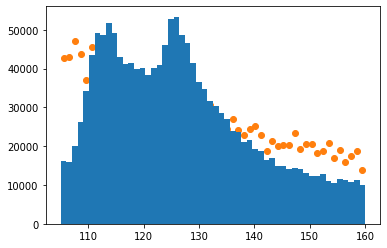

In [17]:
plt.bar(bin_mid, mc_hist, width=bin_size)
plt.scatter(bin_mid, data_hist/data_hist.sum()*mc_hist.sum())

In [18]:
test = uproot.open(os.path.join("root://", data_path, "GamGam", "MC", f"{datasets['GamGam']['MC'][0][0]}.root"))

In [19]:
test["mini"].keys()

[b'runNumber',
 b'eventNumber',
 b'channelNumber',
 b'mcWeight',
 b'scaleFactor_PILEUP',
 b'scaleFactor_ELE',
 b'scaleFactor_MUON',
 b'scaleFactor_PHOTON',
 b'scaleFactor_TAU',
 b'scaleFactor_BTAG',
 b'scaleFactor_LepTRIGGER',
 b'scaleFactor_PhotonTRIGGER',
 b'trigE',
 b'trigM',
 b'trigP',
 b'lep_n',
 b'lep_truthMatched',
 b'lep_trigMatched',
 b'lep_pt',
 b'lep_eta',
 b'lep_phi',
 b'lep_E',
 b'lep_z0',
 b'lep_charge',
 b'lep_type',
 b'lep_isTightID',
 b'lep_ptcone30',
 b'lep_etcone20',
 b'lep_trackd0pvunbiased',
 b'lep_tracksigd0pvunbiased',
 b'met_et',
 b'met_phi',
 b'jet_n',
 b'jet_pt',
 b'jet_eta',
 b'jet_phi',
 b'jet_E',
 b'jet_jvt',
 b'jet_trueflav',
 b'jet_truthMatched',
 b'jet_MV2c10',
 b'photon_n',
 b'photon_truthMatched',
 b'photon_trigMatched',
 b'photon_pt',
 b'photon_eta',
 b'photon_phi',
 b'photon_E',
 b'photon_isTightID',
 b'photon_ptcone30',
 b'photon_etcone20',
 b'photon_convType',
 b'tau_n',
 b'tau_pt',
 b'tau_eta',
 b'tau_phi',
 b'tau_E',
 b'tau_isTightID',
 b'tau_tru

In [20]:
test_events = next(test["mini"].iterate(["mcWeight", "SumWeights", "scale*", "photon_*"], entrystop=10))

In [22]:
test["mini"].numentries

576491